# Partially (positive) labeled datasets

We are considering a set of datapoints $\{(x^i,t^i,y^i)\}$ where $x^i \in mathbb{R}^n$ and $y^i,t^i \in \{0,1\}$ are binary labels. The $t^i$ are the true labels of the data and the $y^i$ labels are defined by

$$y^i = 1 ~ \text{iff} ~ x^i ~\text{is labeled}$$

We further assume that 

$$ y^i = 1 \implies t^i = 1 $$
$$ p(y^i = 1 \, | \, t^i = 1, x^i) = p(y^i = 1 \,| \,t^i = 1)$$

In english, this means that the set of labeled data points is a subset of the set of positive examples and that
the subset of labeled examples is selected independently of the inputs $x^i$ from among the set of positive examples.


## Part (a)

Show that there is a constant (independent of x^i) $\alpha$ so that 

$$p(t^i = 1 | x^i) = p(y^i = 1 | x^i)/\alpha$$


### Notation and formulas for conditional distributions

If $X_1, \dots, X_n$ are random variables, $f_{X_1,\dots,X_n}$ is there joint distribution. We will write $f_{X_i|X_j}$ for the conditional distribution of $X_i$ with respect to $X_j$. Then, we have the following formulas which follow directly from the definitions:


$$f_{X|Y} = f_{X|Y,Z}f_Z$$
$$f_{X|Y,Z} = f_{Y|X,Z}\frac{f_{X|Z}}{f_{Y|Z}} $$

Using these, we have 

$$\frac{f_{y^i | x^i}}{f_{t^i|x^i}} = \frac{f_{y^i|x^i,t^i}}{f_{t^i|y^i,x^i}}$$

and if we evaluate at $y^i,t^i = 1$, the denominator is equal to 1 and the numerator is equal to $p(y^i = 1 | t^i = 1)$ by the two assumptions. Hence $\alpha = p(y^i = 1 | t^i = 1)$.


## Part (b)

Suppose that $V$ is a held out validation set $V$. Let $V_+$ be the subset of labeled examples, and assume that 
$p(t^i = 1 | x^i) \sim 1$ and that $h$ is a trained model, i.e. $h(x^i) \sim p(y^i = 1 | x^i)$. Show that $h(x^i) \sim \alpha$ for all $x^i \in V_+$.

$$\alpha = \frac{p(y^i = 1 | x^i)}{p(t^i = 1 | x^i)} \sim \frac{h(x^i)}{1}$$

## Part (c)

In [1]:
import numpy as np
import util
from p01b_logreg import LogisticRegression

In [35]:
## Load the training and testing datasets for this problem.

x_train , t_train = util.load_dataset('../data/ds3_train.csv',label_col='t',add_intercept=True)
_ , y_train = util.load_dataset('../data/ds3_train.csv',label_col='y')
x_test , t_test = util.load_dataset('../data/ds3_test.csv', label_col='t')

## Train the model using t labels and predict the test set labels using this model

t_model = LogisticRegression()
t_model.fit(x_train,t_train)
t_predicted_t_trained = t_model.predict(x_test)

## Train another model using y labels
y_model = LogisticRegression()
y_model.fit(x_train,y_train)

## Modify the prediction function to output an array of predicted probabilities of a given array:

def predict_probs(x,model):
    '''
    Args:
        x: an (m,n) shape array whose rows are the ith element of input data.
        model: a logreg classifier trained to predict the labels of the inputs x
        
    Returns: An (m,) shape array whose ith entry is the value of h(x^i,\theta) \sim p(y^i = 1 | x^i)
    '''
    return np.reciprocal(1 + np.exp(- util.add_intercept(x) @ model.theta))

y_probs_x_test = predict_probs(x_test,y_model)

## Now use the y model to estimate the parameter alpha.

# Load the validation set:

x_val , t_val = util.load_dataset('../data/ds3_valid.csv',label_col='t')
x_val_pos = x_val[y_val == 1 , :]

alpha = np.mean(predict_probs(x_val_pos,y_model),axis=0)

## Now predict the t labels using the y trained model and the estimated alpha parameter. 

t_predicted_y_trained = (y_probs_x_test > 0.5 * alpha).astype(np.int8)

## How close are the t_predicted_t_trained and t_predicted_y_trained?
t_trained_vs_y_trained =  1 - np.absolute(t_predicted_y_trained - t_predicted_t_trained).mean()
accuracy = 1 - np.absolute(t_predicted_y_trained - t_val).mean()

print('The alpha adjusted predictions match those of the t-trained mode on {:.5} percent of the dataset'.format(t_trained_vs_y_trained*100))
print('The alpha adjusted predictions are {:.5} percent accurate the test dataset'.format(accuracy))

The alpha adjusted predictions match those of the t-trained mode on 96.774 percent of the dataset
The alpha adjusted predictions are 0.95161 percent accurate the test dataset


### We now make three plots of the test dataset which including a decision boundary found by:

- logreg trained with t labels 
- logreg trained with y labels
- logreg trained with y labels and adjusted using the alpha parameter calculated from validation set.

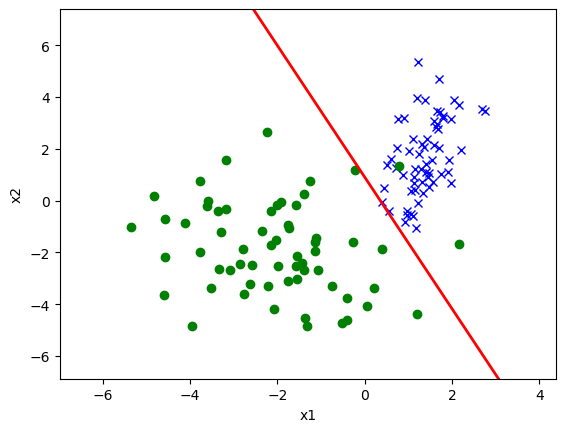

In [3]:
## First plot the decision boundary found by logreg trained using the t labels.

util.plot(x_test,t_test,include_decision=True, theta = t_model.theta)

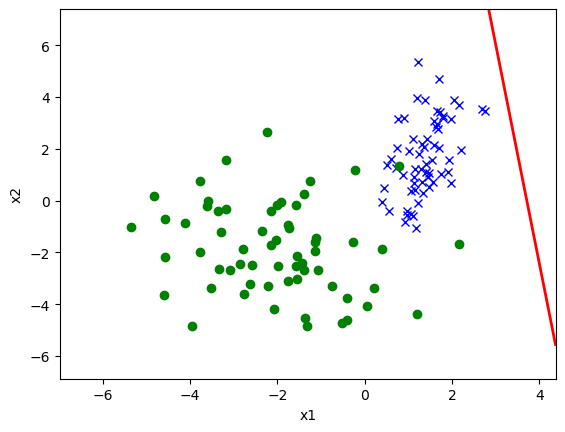

In [4]:
## Next plot the same dataset with the decision boundary obtained by training with respect to the y labels

util.plot(x_test,t_test,include_decision=True,theta=y_model.theta)

### To find the decision boundary of the y-trained model adjusted by alpha:

Recall that we are predicting $t^i=1$ when 

$$p(t^i=1 | x^i) = p(y^i=1|x^i)/\alpha = h(x^i,\theta)/\alpha > 0.5$$

Therefore the decision boundary is the line $x\cdot\theta = f(\alpha/2)$ where $f(y) = \log \frac{y}{1-y}$ is the inverse to the logistic function $g(z) = (1 + e^{-z})^{-1}$.

We let $\beta = f(\alpha/2)$.

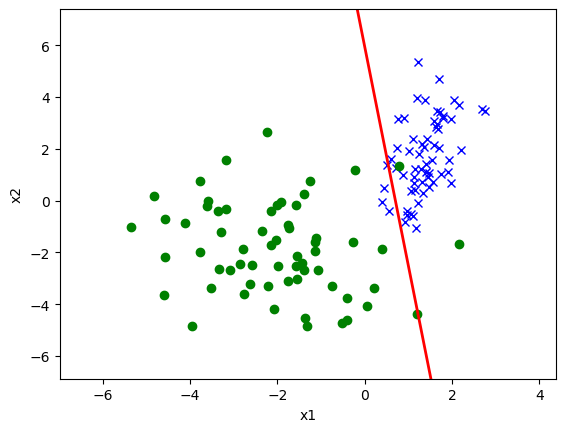

In [36]:
## To make the plot, first calculate beta.

beta = np.log(alpha/(2-alpha))
new_theta = y_model.theta - beta * np.array([1,0,0])

## Now call the modified plot function (see util.py for what the code does when Q2E=True)

util.plot(x_test,t_test,include_decision=True,theta=new_theta)